In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import torch
from druxai.models.NN_minimal import Interaction_Model
from druxai.utils.data import DrugResponseDataset
from druxai.utils.dataframe_utils import split_data_by_cell_line_ids, standardize_molecular_data_inplace
from torch.utils.data import DataLoader
import pandas as pd
from scipy.stats import spearmanr
from druxai.utils.plotting import plot_ordered_r_scores

In [23]:
# Checkpoint path
# Always safe specific config with a run! Important especially if seed is changed because then we have other splits!

ckpt_path = "/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/results/training/ckpt_sgd_baseline.pt"

checkpoint = torch.load(ckpt_path)
cfg = checkpoint["config"]

In [24]:
# Load data
data = DrugResponseDataset(cfg["DATA_PATH"])
train_id, val_id, test_id = split_data_by_cell_line_ids(data.targets, seed=cfg["SEED"])
standardize_molecular_data_inplace(data, train_id, val_id, test_id)

val_loader = DataLoader(
    data,
    sampler=val_id,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=6,
    persistent_workers=True
)

train_loader = DataLoader(
    data,
    sampler=train_id,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=6,
    persistent_workers=True
)

INFO     Loaded targets with shape: (556840, 8)                                                                    
INFO     Loaded molecular data with shape: (1479, 19193)                                                           


In [25]:
model = Interaction_Model(data)

model.load_state_dict(checkpoint["model"])
model.to("mps")
# Setup optimizers

predictions = []
targets = []
cell_lines = []
drugs = []
keys = []
with torch.no_grad():
    model.eval()
    for X, y, idx in val_loader:
        drug, molecular, outcome = (
            X["drug_encoding"].to("mps"),
            X["gene_expression"].to("mps"),
            y.to("mps")
        )

        # Assuming model.predict returns the predicted values
        prediction = model.forward(drug, molecular).reshape(-1).tolist()
        predictions.append(prediction)

        targets.append(y.reshape(-1).tolist())

        # Fetch cell line and drug from data.targets DataFrame
        cell_line = data.targets.iloc[idx]["cell_line"].to_list()
        compound = data.targets.iloc[idx]["DRUG"].to_list()

        cell_lines.append(cell_line)
        drugs.append(compound)
        keys.append([id.item() for id in idx])

In [26]:
data_dict = {
    "ID": keys,
    "Prediction": predictions,
    "Target": targets,
    "cell_line": cell_lines,
    "Drug": drugs
}

# Create a DataFrame from the dictionary
results_df_val = pd.DataFrame(data_dict).apply(pd.Series.explode)

print(f"Overall R-Score: {spearmanr(results_df_val['Prediction'], results_df_val['Target'])[0]} \n")
print(results_df_val.head())

Overall R-Score: 0.7740273589650883 

     ID Prediction    Target   cell_line         Drug
0   218   0.233937  0.438643  ACH-000007   CYTARABINE
0   616   0.294681   0.36191  ACH-000007   EPINASTINE
0  1042  -0.514908 -0.883103  ACH-000007  FLOXURIDINE
0  1499  -0.454179 -0.430022  ACH-000007   VALRUBICIN
0  1940   0.122839  0.340511  ACH-000007    ADAPALENE


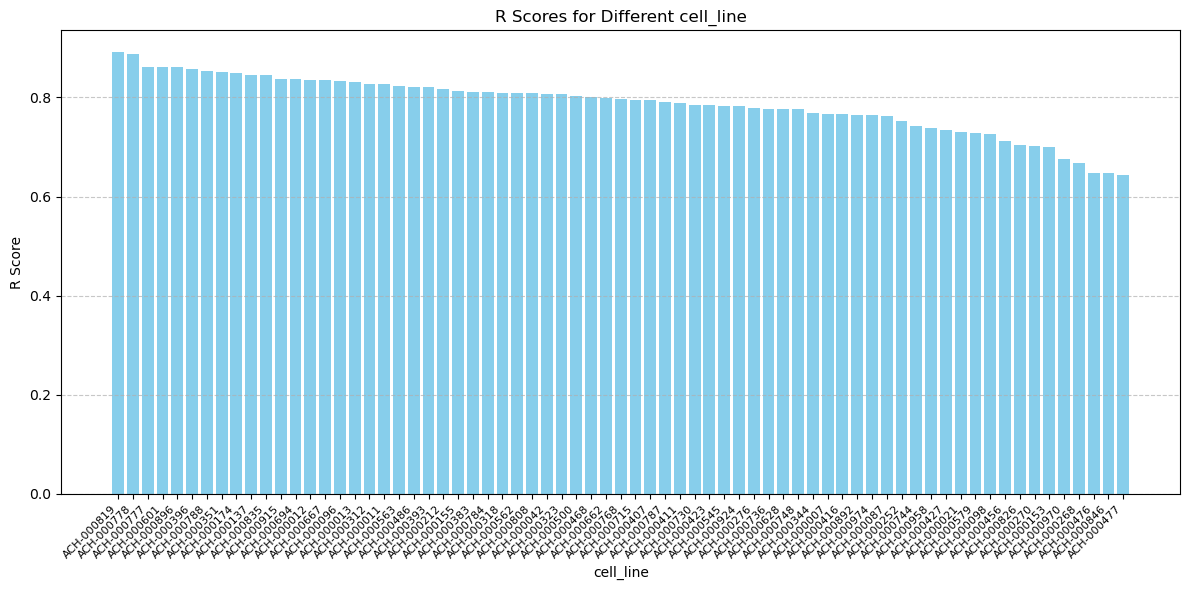

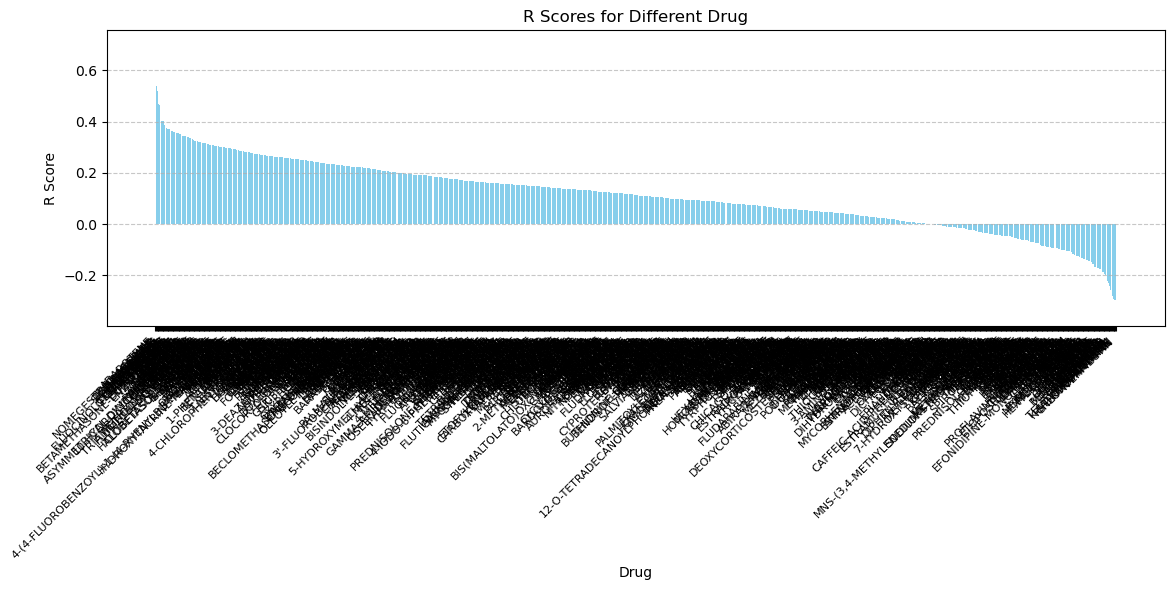

In [27]:
# Calculate R score for each cell line
group_by_features = ["cell_line", "Drug"]
grouped_dfs_val = {}
for group_by_feature in group_by_features:
    grouped_dfs_val[group_by_feature] = plot_ordered_r_scores(results_df_val, group_by_feature)

In [28]:
grouped_dfs_val["cell_line"]

,Group,R Score
58,ACH-000819,0.890945
53,ACH-000778,0.888324
52,ACH-000777,0.861880
41,ACH-000601,0.861534
63,ACH-000896,0.861243
...,...,...
67,ACH-000970,0.674969
15,ACH-000268,0.667004
33,ACH-000476,0.648017
61,ACH-000846,0.646544


In [29]:
grouped_dfs_val["Drug"]

,Group,R Score
42,ADAROTENE,0.703571
710,NOMEGESTROL-ACETATE,0.568340
185,BUCLADESINE,0.539496
339,DORZOLAMIDE,0.518009
814,PHENELZINE,0.468499
...,...,...
552,K-STROPHANTHIDIN,-0.281818
496,HYDROCORTISONE,-0.293706
1070,TRYPTANTHRIN,-0.295454
236,CHLOROPYRAMINE,-0.296491


## Prediction on Train set

In [49]:
model = Interaction_Model(data)

model.load_state_dict(checkpoint["model"])
model.to("mps")
# Setup optimizers

predictions = []
targets = []
cell_lines = []
drugs = []
keys = []
with torch.no_grad():
    model.eval()
    for X, y, idx in train_loader:
        drug, molecular, outcome = (
            X["drug_encoding"].to("mps"),
            X["gene_expression"].to("mps"),
            y.to("mps")
        )

        # Assuming model.predict returns the predicted values
        prediction = model.forward(drug, molecular).reshape(-1).tolist()
        predictions.append(prediction)

        targets.append(y.reshape(-1).tolist())

        # Fetch cell line and drug from data.targets DataFrame
        cell_line = data.targets.iloc[idx]["cell_line"].to_list()
        compound = data.targets.iloc[idx]["DRUG"].to_list()

        cell_lines.append(cell_line)
        drugs.append(compound)
        keys.append([id.item() for id in idx])

Overall R-Score: 0.7990087800903263 

     ID Prediction    Target   cell_line             Drug
0   608   0.292296  0.184613  ACH-000008       EPINASTINE
0  1031  -0.514883 -0.528086  ACH-000008      FLOXURIDINE
0  1488  -0.453142 -0.449311  ACH-000008       VALRUBICIN
0  2335   0.287071  0.200556  ACH-000008  METHYLPHENIDATE
0  2735   0.151039  0.115816  ACH-000008      FULVESTRANT


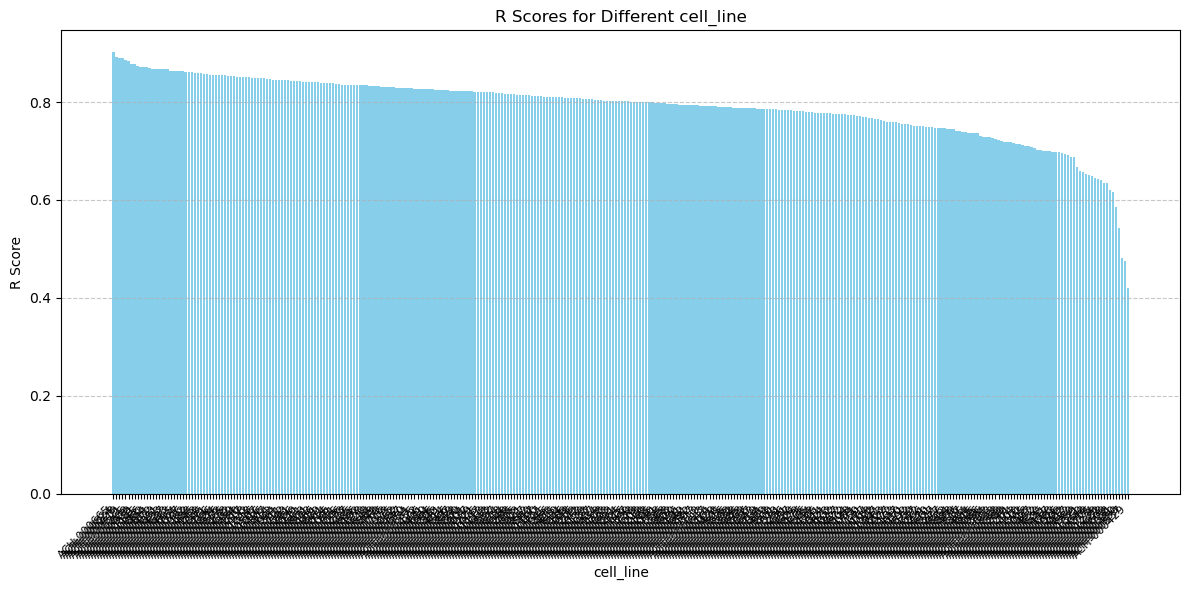

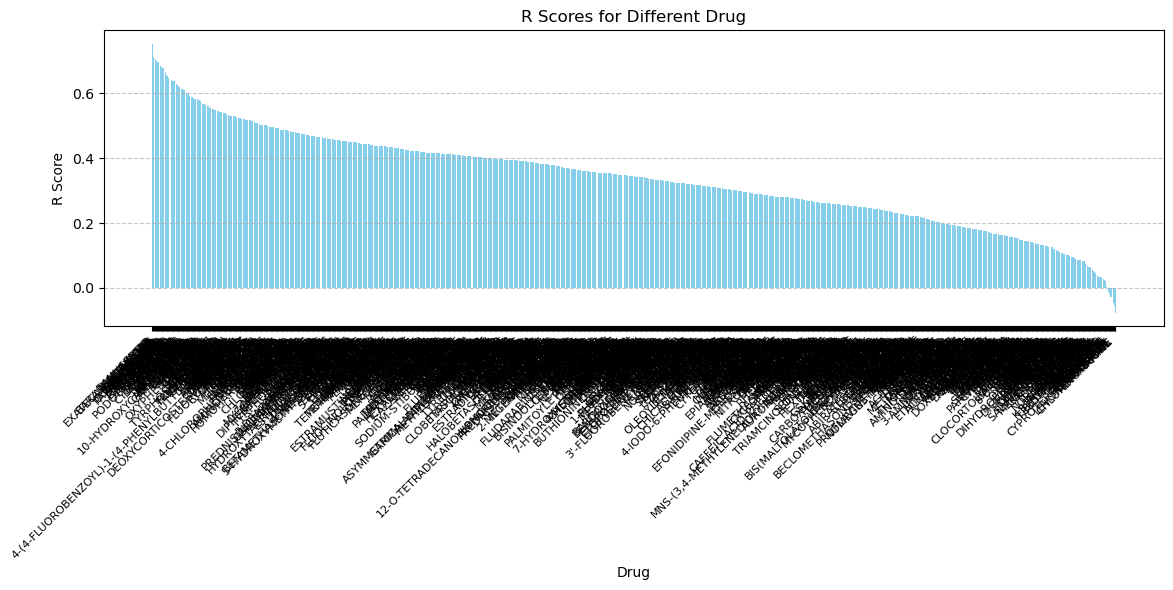

In [50]:
data_dict = {
    "ID": keys,
    "Prediction": predictions,
    "Target": targets,
    "cell_line": cell_lines,
    "Drug": drugs
}

# Create a DataFrame from the dictionary
results_df_train = pd.DataFrame(data_dict).apply(pd.Series.explode)

print(f"Overall R-Score: {spearmanr(results_df_train['Prediction'], results_df_train['Target'])[0]} \n")
print(results_df_train.head())

# Calculate R score for each cell line
group_by_features = ["cell_line", "Drug"]
grouped_dfs_train = {}
for group_by_feature in group_by_features:
    grouped_dfs_train[group_by_feature] = plot_ordered_r_scores(results_df_train, group_by_feature)

In [15]:
grouped_dfs_train["cell_line"]

,Group,R Score
191,ACH-000665,0.901354
252,ACH-000824,0.891808
51,ACH-000228,0.890631
174,ACH-000619,0.890145
142,ACH-000521,0.885026
...,...,...
87,ACH-000331,0.584805
130,ACH-000480,0.542168
93,ACH-000359,0.481301
148,ACH-000537,0.474613


In [16]:
grouped_dfs_train["Drug"]

,Group,R Score
301,DANUSERTIB,0.751976
962,SN-38,0.710073
396,EXATECAN-MESYLATE,0.707151
130,BARASERTIB-HQPA,0.706720
963,SNS-314,0.703794
...,...,...
1080,UBENIMEX,-0.035661
585,LEVONORGESTREL,-0.046205
375,EQUOL,-0.047399
361,ENOXIMONE,-0.055234


## Check Correlation between cell_lines type count vs predicted values

Is there a correlation between a cell_line which does not have many observation in terms of prediction vs highly presented ones
Same for drugs. 



In [36]:
val_cell_line_ranks = data.targets.iloc[val_id].groupby("cell_line")["DRUG"].nunique().sort_values().rank()
val_cell_line_ranks = pd.DataFrame(val_cell_line_ranks)

df1 = grouped_dfs_val["cell_line"].set_index("Group")
df2 = val_cell_line_ranks

merged_df = df1.join(df2)
correlation = merged_df["R Score"].corr(merged_df["DRUG"])

print("Val Correlation between R Score and rank:", correlation)

In [51]:
train_cell_line_ranks = data.targets.iloc[train_id].groupby("cell_line")["DRUG"].nunique().sort_values().rank()
train_cell_line_ranks = pd.DataFrame(train_cell_line_ranks)

df1 = grouped_dfs_train["cell_line"].set_index("Group")
df2 = train_cell_line_ranks

merged_df = df1.join(df2)
correlation = merged_df["R Score"].corr(merged_df["DRUG"])

print("Train Correlation between R Score and rank:", correlation)

Train Correlation between R Score and rank: 0.30621101188951766
